In [1]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re


PCA_color_ref= ['darkseagreen','crimson', 'darkorange', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink']

%matplotlib inline

## Genome sampler

**I.**

Perform PCA across consecutive windows of genomic SNP data. Visualize variation across given axes. Calculate deviation from 
mean for individual populations.

**II.**

Use magnitude of confidence intervals in PCA space as amplitude of sound wave. 

**III.**

Dissect sound sample. Read, plot spectrogram. Apply filters and use mean shift to isolate peak significant frequencies. 

Cluster peaks into groups with stable frequency. Replace cluster amplitude with most similar equivalent in geno data.

Reconstruct song.


## Input

In [2]:
from structure_tools.vcf_geno_tools import simple_read_vcf

vcf_file= 'data_val_g30d0.40s10.vcf'

genotype, summary, info_save= simple_read_vcf(vcf_file,row_info= 5,header_info= 9,phased= False)

print('Number of markers: {}'.format(genotype.shape[1]))
print('Number of individuals: {}'.format(genotype.shape[0]))



Number of markers: 18881
Number of individuals: 110


In [3]:
from structure_tools.Tutorial_subplots import plot_global_pca

## Perform PCA
n_comp= 3

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')

feats= pca.fit_transform(genotype)
## perform MeanShift clustering.
bandwidth = estimate_bandwidth(feats, quantile=0.2)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=True, min_bin_freq=25)
ms.fit(feats)
labels1 = ms.labels_
label_select = {y:[x for x in range(len(labels1)) if labels1[x] == y] for y in sorted(list(set(labels1)))}

###
plot_global_pca(feats,label_select,PCA_color_ref,title= 'global_pca',height= 500,width= 950)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### Local Analysis

Analyse genetic variation across genomic windows. Begin by chosing the size of each window (`window_size`) and the distance between windows (in number of markers, `Steps`).

In [4]:
from structure_tools.vcf_geno_tools import geno_window_split
##### 
window_size= 150
Steps= 20

Windows, Out= geno_window_split(genotype,
                                summary,
                                Steps= Steps,
                                window_size=window_size)

print('number of chromosomes: {}'.format(len(Windows)))
print('number of windows: {}'.format(sum([len(Windows[x].keys()) for x in Windows.keys()])))


number of chromosomes: 1
number of windows: 938


###  Variation across windows


Chose:

- a range of windows; 
- populations; 
- principal components to keep.

Perform PCA at each window. For each population, centre samples from that pop by PC. Extract coordinates for the PC selected.

Calculate the confidence interval of the selected samples across data sets (mean is now 0). Extract the distance between upper and lower bounds. 


In [5]:
from structure_tools.vcf_geno_tools import window_analysis

dict_coords= {}
Windows_range_pca= [100,350]
ref_labels= [2,3,4]

group_list= [2,2]
PC_selection= [1,2]

for access in range(len(group_list)):
    include_who= [group_list[access]]
    

    Frequencies, sim_fst, Results, Construct, pc_density_s, pc_coords_s, fst_fig= window_analysis(Windows,
                                                                                     ref_labels,
                                                                                     labels1,
                                                                                     Chr= 1,
                                                                                     ncomp= 4,
                                                                                     amova= False,
                                                                                     supervised= True,
                                                                                     include_who= include_who,
                                                                                     range_sample= Windows_range_pca,
                                                                                     rand_sample= 0,
                                                                                     clsize= 15,
                                                                                     cl_freqs= 5,
                                                                                     Bandwidth_split= 20,
                                                                                     quantile= .2,
                                                                                     centre_d= True,
                                                                                     PC_sel= PC_selection[access] - 1)
    
    labels_code_s= labels1

    if include_who:
        labels_code_s= [x for x in labels_code_s if x in include_who]
    
    dict_coords[access]= {
        'coords': pc_coords_s,
        'dens': pc_density_s,
        'labs': labels_code_s
    }



In [6]:
from structure_tools.Tutorial_subplots import PC_analysis_plot
from plotly import tools

titles= ['Gp{}; PC{}; range: {}'.format(group_list[x],PC_selection[x],'-'.join([str(x) for x in Windows_range_pca])) for x in range(len(group_list))]
Ncols= 1
print(titles)

fig_subplots = tools.make_subplots(rows= len(titles), cols=Ncols,
                         subplot_titles=tuple(titles))

for gp in range(len(titles)):

    pos1= gp + 1
    pos2= 1
    
    include_who= [group_list[gp]]
    
    title= titles[gp]


    fig= PC_analysis_plot(dict_coords[gp]['dens'],dict_coords[gp]['coords'],dict_coords[gp]['labs'],PCA_color_ref,range_windows= Windows_range_pca,
                     plot_choice= 'coords',height= 400,width= 1000,y_range= [-9,12],qtl= .99,PC_sel= PC_selection[gp])
    
    for trace1 in fig['data']:

        fig_subplots.append_trace(trace1, pos1, pos2)


    fig_subplots['layout']['yaxis' + str(gp + 1)].update(title=fig['layout']['yaxis']['title'])

    fig_subplots['layout']['xaxis' + str(gp + 1)].update(title=fig['layout']['xaxis']['title'])



fig_subplots['layout'].update(height= 700,width= 900)
iplot(fig_subplots)


['Gp2; PC1; range: 100-350', 'Gp2; PC2; range: 100-350']
This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]

250
(250, 2)
250
(250, 2)


## Sound from amp

We will use the standard deviation of a single population across a given component as the amplitude of a audio signal.

First select the group, PC and range of local windows to use. We run the `window_analysis` function to extract centred PCA coordinates. Then use each data set as frames and the boundary distance as amplitude. To produce sound select a frequency, a total length in seconds and a sample rate. Amplitude is interpolated for the extra frames necessary to make the range of windows selected above to fit `length / sample rate`.

### A single sample. PC var as amplitude.

In [7]:
from music_tools.my_music_tools import get_sound_coords
import music_tools.thinkdsp as thinkdsp
import music_tools.thinkplot as thinkplot

qtl= 0.95

group= 2
PC_select= 1

sampleRate = 44100
frequency = 1800
length = 10


fig_test, wave_s= get_sound_coords(dict_coords[0]['coords'],
                               sampleRate= sampleRate,
                                    frequency= frequency,
                                length= length,
                                group= group,
                                PC_select= PC_select)


fig_test['layout'].update(height= 400,width= 900)
iplot(fig_test)

In [8]:
wave_s.make_audio()

### Multiple tracks.

The truth is that a sound signal is more complicated than a single sin waved capped by amplitude boundaries. 

Multiple frequencies go into making most sounds. What we hear is the concatenation of those signals on different amplitudes (litterally the sum of the different sin waves). It is thus quite synthetic to want a more concrete sound out of genetic data if it only gives us the amplitude. 

But we can try. 

The idea in this section is to use the amplitude idea above, only apply it to more than one track and at different frequencies to simulate a given song. 

**Disclaimer** this really only works with very clean sound. 

**Disclaimer II** much core code below was compied from Allen Downey's github ([thinkDSP](https://github.com/AllenDowney/ThinkDSP)) as were the sound samples (sax and violin) used for testing and development.  

We will begin by reading a sound file. in this case one of the .wav samples provided by AD. We will use the librosa library to read the file into its collection of amp by frame and sample rate components.

Then we will use the fourrier transform to transform the wave into its component frequencies. 
I have left the choice of library (librosa or thinkdsp) to the user. The output is a bit different i dont know why yet i think librosa does some processing of the fourrier output.

In [9]:

from __future__ import print_function
import librosa

Home= 'Samples/'
# 1. Get the file path to the included audio example
filename = Home + '92002__jcveliz__violin-origional.wav'
filename = Home + '100475__iluppai__saxophone-weep.wav'
#filename = Home + '105977__wcfl10__favorite-station.wav'
#filename = Home + 'harry_potter_theme.mp3'
#filename= Home + 'imperialmarch.mp3'


# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
y_wav, sr = librosa.load(filename)

In [10]:
## keep and plus  are here to subset a vector from any sample exceeding 10s in length at Sr > 2200.
## Necessary for smallih PCs, like mine..
keep= 10
plus= 0
#y_keep= y_wav[(plus*sr):(plus*sr+keep * sr)]
y_keep= y_wav

In [11]:
wave_vio= thinkdsp.Wave(y_keep,framerate=sr)

wave_vio.make_audio()

### Processing a sound track.

Extracting the spectrogram.

**important**

The Fourier transform is not applied across the sample. Frames are split into overlapping windows, and the transform is applied at each window. 

- `seg_length` determines the length of the window. tdsp library uses steps of size len(seg_length) // 2. librosa allows for a user determined step.

- `height` determines a frequency cap. 

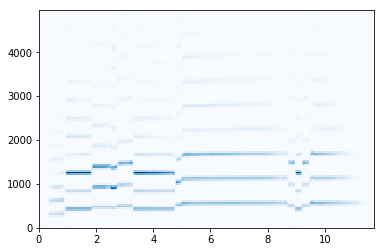

In [12]:
seg_length= 512

height= 5000
spectrogram = wave_vio.make_spectrogram(seg_length= seg_length)
spectrogram.plot(high=height)

### Extracting frequencies. 

Our goal will be to adjust genome samples to individual frequency tracks along this sample. 

However, this is made complicated by the fact that the values, observed on the spectrogram above, are continuous. This means we must first extract the bands that we see there. 


We begin by extracting the information stored in the spectrogram:

- a matrix of continuous amplitude values: `array_spec`

- a vector of time.

- a vector of frequencies.

Chose between librosa and tdsp libraries for extraction below. 


In [13]:
from music_tools.my_music_tools import find_index, return_spec_array

method_list= ['tdsp','librosa']
method_pick= 0

method= method_list[method_pick]

### using librosa

seg_length= 512
height= 5000

if method == 'librosa':
    
    step = int(seg_length // 2)
    n_mels= 128

    array_spec = librosa.feature.melspectrogram(y=y, hop_length=step,
                                                    fmax=height, n_fft= seg_length, sr= sr, n_mels= n_mels)

    spec_fs= np.linspace(0,height,n_mels,seg_length)
    spec_ts= np.arange(0,len(y),step)
    spec_ts= (spec_ts / len(y)) * (len(y) /sr)

if method == 'tdsp':
    
    spectrogram = wave_vio.make_spectrogram(seg_length= seg_length)
    array_spec, spec_ts, spec_fs= return_spec_array(spectrogram,high= height)
    array_spec.shape


### A closer look at the spectrogram. 

To get a better understanding of the problem we face we look at the amplitude values for a single frame of the spectrogram.

In [14]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs
from music_tools.my_music_tools import plot_frame, cluster_threshold, frame_peaks

frame_plot= 50
plot_frame(array_spec,frame_plot,spec_fs,height= 400,width= 900)

### Peak extraction - clustering

The peaks above represent the local expression of the wider bands observed along the spectrogram above. 

The problem of isolating separate bands is, at this level, the problem of identifying these peaks.

The solution i propose here is a combination of filtering and unsupervised clustering: 

- i. a minimum threshold below which values are set to 0, an initial filter. 
- ii. a cap on maximum values. 
- iii. using the resulting vector of amplitudes as the probabilities of frequency values; sample from fs using prob. vector. 

- iv. Use meanshift clustering to identify clusters of frequency values (bandwidth is important). 
- v. a second filter step: group cluster centers by proximity (user defined threshold)


In [15]:

frame= 134
Sample_N= 500 
p_threshold= 0.0004 
amp_cap= 5 # max amp cap.
peak_cap= 1.5 # min amp cap.
peak_iso= 200 # cluster centre proximity cap. 
band_qtl= 0.02 # MS qtl
frame_plot= True


peak_cent, time_spec, amps_centres, figure_frame= frame_peaks(array_spec, spec_fs, spec_ts,
                frame= frame,
                Sample_N= Sample_N,
                p_threshold= p_threshold,
                amp_cap= amp_cap,
                peak_cap= peak_cap,
                peak_iso= peak_iso,
                band_qtl= band_qtl,
                frame_plot= frame_plot)



#
iplot(figure_frame)


### Across frames.

If the plot above appears acceptable, perform peak extraction across frames.

In [16]:
##########
##########

frame_many= array_spec.shape[1]
frame_crawl= np.linspace(0,array_spec.shape[1] - 1,frame_many)

ts_list= []
peaks= []
amps= []

Sample_N= 1000
p_threshold= 0.0004
amp_cap= 6
peak_cap= 1.2
peak_iso= 250
band_qtl= 0.11
frame_plot= False


for frame in range(array_spec.shape[1]):

    
    peak_cent, time_spec, amps_centres= frame_peaks(array_spec, spec_fs, spec_ts,
                    frame,
                    Sample_N= Sample_N,
                    p_threshold= p_threshold,
                    amp_cap= amp_cap,
                    peak_cap= peak_cap,
                    peak_iso= peak_iso,
                    band_qtl= band_qtl,
                    frame_plot= frame_plot)
    
    peaks.extend(peak_cent)
    ts_list.extend([spec_ts[frame]]* len(amps_centres))
    amps.extend(amps_centres)


samps_tracks= np.array([
    ts_list,
    peaks,
    amps
]).T


In [17]:
### plot peaks

In [18]:
from music_tools.my_music_tools import filter_output

output_peak_filter= filter_output(samps_tracks)
iplot(output_peak_filter)


#### Clustering peaks

Now, we woul like to separate individual bands, so that we can compare the amplitude of each against our genome samples.

This is because each geno sample will receive a single frequency. So we do not only need separate bands, we need to split them by frequency shift. 

If the plot above looks reasonably clean, then there is a good chance that we can cluster different bands together. the script below allows for two passes of mean shift clustering. One of the things to consider is that we will be treating peaks by cluster. If the peaks belong to bands of the same frequency but separate in time, then a signal will be created that bridges them. If this is still true after a second round of MS, then there is the possibility of reducing clusters to `N_neigh` consecutive peaks. 

In [19]:
from music_tools.my_music_tools import break_down_spec

N_neigh= 0
ms_layer2= True
scale_spec= False
qtl_I= 0.05
qtl_II= 0.1
clst_all_I= True
clst_all_II= True

coords, figures_ms, plot_names= break_down_spec(samps_tracks,N_neigh= N_neigh,
                                    ms_layer2= ms_layer2,
                                    scale_spec= scale_spec,
                                       qtl_I= qtl_I,
                                       qtl_II= qtl_II,
                                       clst_all_I= clst_all_I,
                                       clst_all_II= clst_all_II)



titles= plot_names
Ncols= 1
print(titles)

fig_subplots = tools.make_subplots(rows= len(titles), cols=Ncols,
                         subplot_titles=tuple(titles))

for gp in range(len(titles)):

    pos1= gp + 1
    pos2= 1

    title= titles[gp]


    fig= figures_ms[gp]
    
    for trace1 in fig['data']:

        fig_subplots.append_trace(trace1, pos1, pos2)


    fig_subplots['layout']['yaxis' + str(gp + 1)].update(title=fig['layout']['yaxis']['title'])

    fig_subplots['layout']['xaxis' + str(gp + 1)].update(title=fig['layout']['xaxis']['title'])



fig_subplots['layout'].update(height= 700,width= 900)
iplot(fig_subplots)


['MS1', 'MSII']
This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



#### Mean plots

The code to re-construct the song from geno sound samples will attribute to each sample a constant frequency. This frequency will be estimated as the average frequency across each group. So that the final product will look more like the following:

In [21]:
from music_tools.my_music_tools import meanfreq_plot

mean_plot= meanfreq_plot(samps_tracks,coords,ts_list,peaks,height= 400,width= 900)
iplot(mean_plot)

### Get samples

NOw we are ready to go back to the genome and collect samples that approximate the frequencies in each melody. 

First we will expand the data set of genomic coordinates and confidence interval vectors. 

Again, this algorithm takes as input:

- a list of populations we are interested in: `group_list`
- a list of PCs to retain for each population: `PC_selection`
- a range of windows at which to perform the extraction: `Windows_range_pca`

In [22]:
#######
#######

from structure_tools.vcf_geno_tools import window_analysis

dict_coords= {}
Windows_range_pca= [0,350]
ref_labels= [2,3,4]

group_list= [2,3,4,2]
PC_selection= [1,1,1,2]

for access in range(len(group_list)):
    include_who= [group_list[access]]
    

    Frequencies, sim_fst, Results, Construct, pc_density_s, pc_coords_s, fst_fig= window_analysis(Windows,
                                                                                     ref_labels,
                                                                                     labels1,
                                                                                     Chr= 1,
                                                                                     ncomp= 4,
                                                                                     amova= False,
                                                                                     supervised= True,
                                                                                     include_who= include_who,
                                                                                     range_sample= Windows_range_pca,
                                                                                     rand_sample= 0,
                                                                                     clsize= 15,
                                                                                     cl_freqs= 5,
                                                                                     Bandwidth_split= 20,
                                                                                     quantile= .2,
                                                                                     centre_d= True,
                                                                                     PC_sel= PC_selection[access] - 1)
    
    
    labels_code_s= labels1

    if include_who:
        labels_code_s= [x for x in labels_code_s if x in include_who]
    
    dict_coords[access]= {
        'coords': pc_coords_s,
        'dens': pc_density_s,
        'labs': labels_code_s
    }



We now extract the magnitude of confidence intervals across data set / populations / PCs selected in the previous blocks.

These are stored in the `amp_stock` array. 

In [23]:
from music_tools.my_music_tools import get_amps

sampleRate = sr
length = y_keep.shape[0] / sr

qtl= .95

amp_stock, max_q_list= get_amps(dict_coords,length= length,sampleRate= sampleRate,qtl= qtl)



### Sample comparison

This is where we match sound samples with genome amplitude samples. 

Frame values are analysed by cluster. The amplitude values are scaled and ordered in time. Minimum and maximum time is
used to interpolate amplitude for the number of frames equivalent to _time / sample rate_. Then a pool of (`N_compares`) vectors of consecutive genome magnitudes are selected and scaled. The distance of the real (song) sample vector to all genome vectors is 
calculated using function `distance` of the python module [scipy.spatial](https://docs.scipy.org/doc/scipy/reference/spatial.html). The distance metric is set to "correlation" and the final vector is chosen using the maximum value. 

In [31]:
from music_tools.my_music_tools_IV import match_samples

N_compares= 40
low_N= 2

y_composition= match_samples(samps_tracks,coords,amp_stock, max_q_list,sr= sr,seg_length=seg_length,length= length,low_N= low_N,N_compares= N_compares)

In [32]:
## sounds a bit more natural.

add_noise= noise = np.random.normal(0,0.005,len(y_composition))
y_composition += add_noise

In [33]:
### wave produced

wave_mix= thinkdsp.Wave(y_composition,framerate=sr)

wave_mix.make_audio()


In [45]:
from scipy.io import wavfile

save_samp= True

if save_samp:
    wavfile.write('mix_dirty_I.wav', sr, y_composition)

### Sanity check

Plot the spectrogram of the sample produced next to that of the original sound.

_straight from librosa documentation_

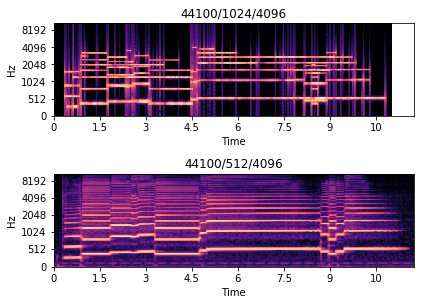

In [36]:
import librosa.display as _display
#from presets import Preset


#librosa = Preset(_librosa)

M = librosa.feature.melspectrogram(y=np.array(y_composition))

# Of course, you can still override the new default manually, e.g.:

M_highres = librosa.feature.melspectrogram(y=y_keep, hop_length=512)


# And plot the results
plt.figure(figsize=(6, 6))
ax = plt.subplot(3, 1, 1)

librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time')

plt.title('44100/1024/4096')

plt.subplot(3, 1, 2, sharex=ax, sharey=ax)
librosa.display.specshow(librosa.power_to_db(M_highres, ref=np.max),
                         hop_length=512,
                         y_axis='mel', x_axis='time')
plt.title('44100/512/4096')

# We can repeat the whole process with different defaults, just by
# updating the parameter entries
#librosa['sr'] = 11025


plt.tight_layout()
plt.show()
